# Image Classification Using Transfer Learning
Horse or Human

## Importing Module

In [1]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf
import matplotlib.image as mpimg


from pathlib import Path
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem

- Build a classifier for the Human or Horse Dataset with Transfer Learning.
- The test will expect it to classify binary classes.
- Note that all the layers in the pre-trained model are non-trainable.
- Do not use lambda layers in your model.
- The horse-or-human dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
- `Inception_v3`, pre-trained model used in this problem is developed by Google.
- Desired accuracy and validation_accuracy > `97%`.

### Preparing data

In [3]:
data_url_1 = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
data_url_2 = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'

train_dir = Path('data/horse-or-human')
val_dir = Path('data/validation-horse-or-human')


list_files = {
    'file_1' : ['horse-or-human.zip', data_url_1, train_dir],
    'file_2' : ['validation-horse-or-human.zip', data_url_2, val_dir]
}

Download Weight Base Model

In [4]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

if os.path.isfile(local_weights_file) == False:
  urllib.request.urlretrieve(inceptionv3, local_weights_file)
  print(f'{local_weights_file} Downloaded')
else:
  print(f'{local_weights_file} Already exist')

inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 Downloaded


Download and Extract data

In [5]:
for data_file in list_files.values():
  try:
    if os.path.isfile(data_file[0]):
      print(f'{data_file[0]} Already exist')
    else:
      # Download data
      urllib.request.urlretrieve(data_file[1], data_file[0])

      # Extract Data
      zip_ref = zipfile.ZipFile(data_file[0], 'r')
      zip_ref.extractall(data_file[2])
      zip_ref.close()
      
      print(f'{data_file[0]} Download and Extract finished')
  except ValueError as e:
    print(e)

horse-or-human.zip Download and Extract finished
validation-horse-or-human.zip Download and Extract finished


Check total file

In [6]:
train_data_path = os.listdir(train_dir)
validation_data_path = os.listdir(val_dir)

# List all data in Train dir
image_count = len(list(train_dir.glob("*/*")))

print(f'Total Image in {train_dir} : {image_count}')
for i in train_data_path:
  target_path = os.path.join(train_dir, i)
  print(f'Total Train Images in {i} : {len(os.listdir(target_path))}')

print()

# List all data in Validation dir
val_image_count = len(list(val_dir.glob("*/*")))
print(f'Total Image in {val_dir} : {val_image_count}')
for i in validation_data_path:
  target_path = os.path.join(val_dir, i)
  print(f'Total Validation Images in {i} : {len(os.listdir(target_path))}')

Total Image in data/horse-or-human : 1027
Total Train Images in humans : 527
Total Train Images in horses : 500

Total Image in data/validation-horse-or-human : 256
Total Validation Images in humans : 128
Total Validation Images in horses : 128


### Explore data

In [7]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

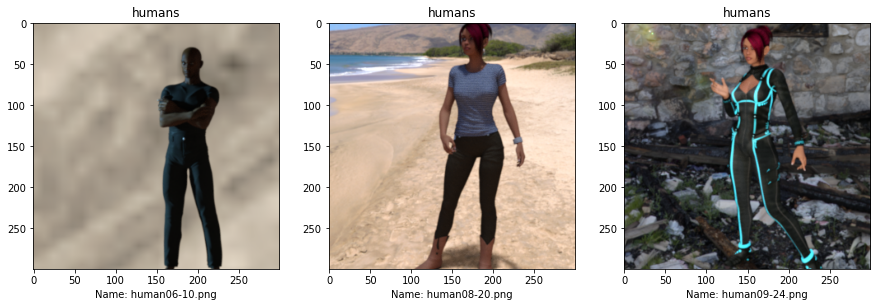

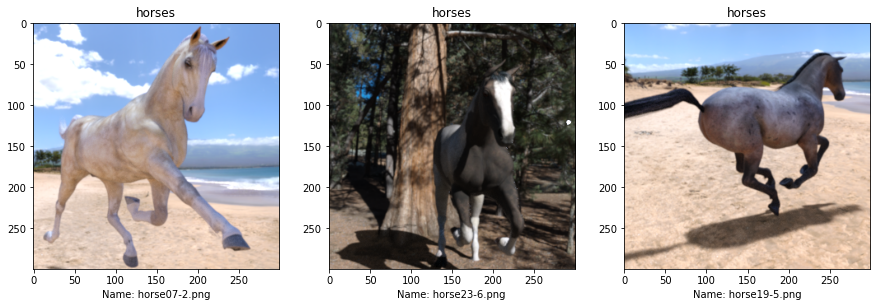

In [8]:
for dir in train_data_path:
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Preparing Train Model

Set Paramters

In [9]:
IMG_SIZE = (150,150)
BATCH_SIZE = 128

#### Image Augmentation
Using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   rotation_range=20, 
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = True,
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE//4,
                                                        shuffle = True,
                                                        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


#### Base Model
Using [inception_v3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3)

In [11]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None)

pre_trained_model.load_weights(local_weights_file)

# Freeze layers
for layer in pre_trained_model.layers:
        layer.trainable = False

In [ ]:
pre_trained_model.summary()

Choose `mixed7` as base layer

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

#### Build Model

In [13]:
def build_model(last_output):
    """
  Create a model using transfer learning as base model

  Returns:
      model (tf.keras Model): the Image classifier model
  """

  # Define Params
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.BinaryCrossentropy()

  # Define Activation Function
  relu = tf.nn.relu
  sigmoid = tf.nn.sigmoid

  # Connect base layer to fully connected layer
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(units=512, activation=relu)(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(units=1, activation=sigmoid)(x) # Output

  # Define model
  model = tf.keras.Model(pre_trained_model.input, x)

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

In [15]:
model = build_model(last_output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

#### Define Callbacks

In [16]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=4, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[model_checkpoint, early_stopping],
      validation_steps=8)

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9287
Epoch 1: val_accuracy improved from -inf to 0.99609, saving model to model.h5
8/8 [==============================] - 27s 2s/step - loss: 0.1072 - accuracy: 0.9287 - val_loss: 0.0226 - val_accuracy: 0.9961
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9978
Epoch 2: val_accuracy did not improve from 0.99609
8/8 [==============================] - 10s 1s/step - loss: 0.0039 - accuracy: 0.9978 - val_loss: 0.0344 - val_accuracy: 0.9922
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9978
Epoch 3: val_accuracy did not improve from 0.99609
8/8 [==============================] - 10s 1s/step - loss: 0.0200 - accuracy: 0.9978 - val_loss: 0.0647 - val_accuracy: 0.9922
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9967
Epoch 4: val_accuracy did not improve from 0.99609
8/8 [===============

### Visualization result

In [20]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='best')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='best')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

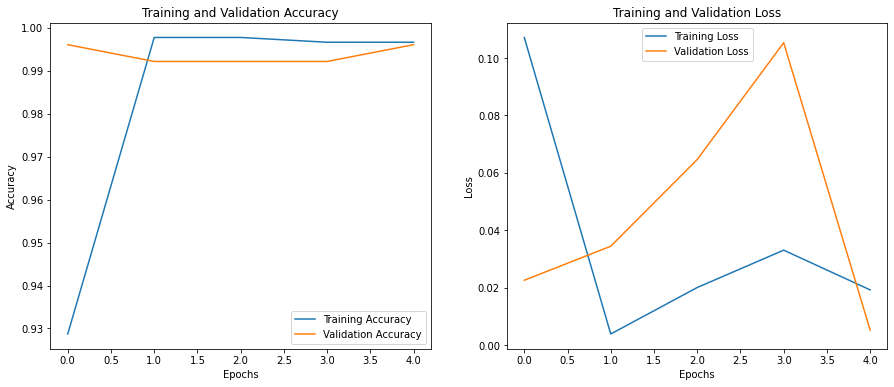

In [21]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download(model.h5)